To see whether my from-scratch SVM performs on real-world data, I'll test it on just that. The dataset I chose is obtained from the YBI foundation, and includes a few features regarding credit card users and whether or not they defaulted on their loan.

In [101]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from models import SupportVectorMachine
from utils.data_utils import split_dataset

# Testing on Credit Card Dataset

In [102]:
# load data
filename = 'datasets/credit_default.csv'
df = pd.read_csv(filename)

In [103]:
# first 5 samples
df.head()

,Income,Age,Loan,Loan to Income,Default
0,66155.92510,59.017015,8106.532131,0.122537,0
1,34415.15397,48.117153,6564.745018,0.190752,0
2,57317.17006,63.108049,8020.953296,0.139940,0
3,42709.53420,45.751972,6103.642260,0.142911,0
4,66952.68885,18.584336,8770.099235,0.130990,1


In [104]:
# basic stats
df.describe()

,Income,Age,Loan,Loan to Income,Default
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,45331.600018,40.927143,4444.369695,0.098403,0.141500
std,14326.327119,13.262450,3045.410024,0.057620,0.348624
min,20014.489470,18.055189,1.377630,0.000049,0.000000
25%,32796.459720,29.062492,1939.708847,0.047903,0.000000
50%,45789.117310,41.382673,3974.719418,0.099437,0.000000
75%,57791.281670,52.596993,6432.410625,0.147585,0.000000
max,69995.685580,63.971796,13766.051240,0.199938,1.000000


In [105]:
# quantity of default vs no default
df.Default.value_counts()

Default
0    1717
1     283
Name: count, dtype: int64

<Axes: >

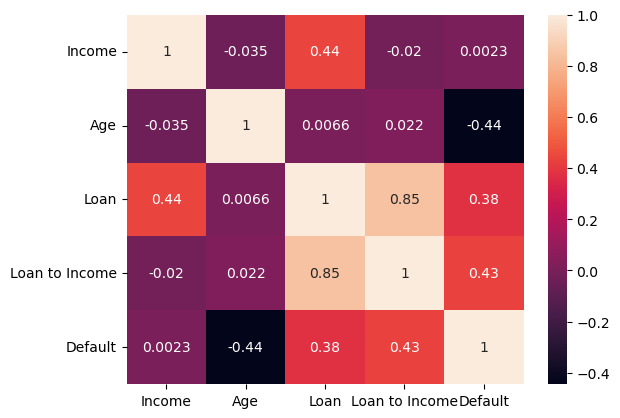

In [106]:
# visual check for multicollinearity
sns.heatmap(df.corr(), annot=True)

In [107]:
# testing whether loan to income is just loan / income
np.all(np.isclose(df['Loan'] / df['Income'], df['Loan to Income']))

np.True_

Yes, it is. This would explain why Loan is heavily correlated with Loan to Income. I'll start by modeling with all features but later will try without Loan to Income to see the impact it has.

In [108]:
# list of features for modeling
features = ['Income', 'Age', 'Loan', 'Loan to Income']

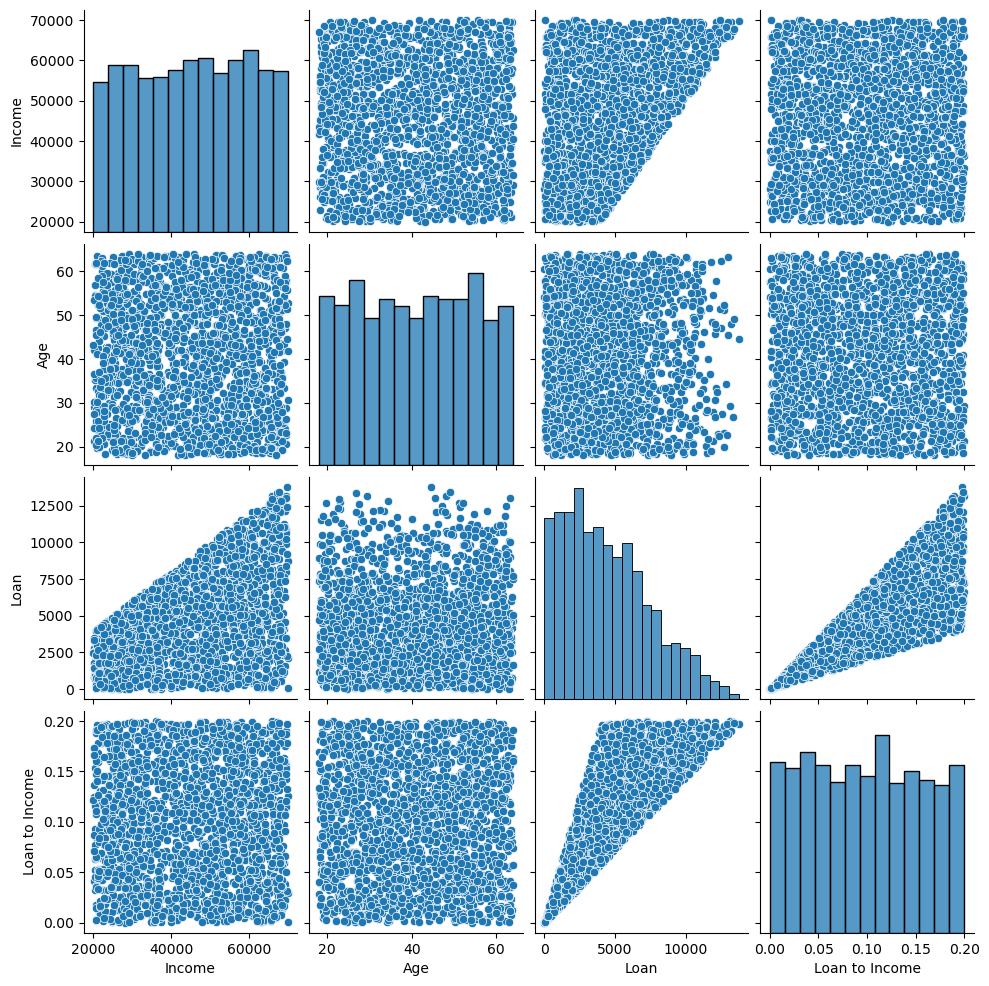

In [109]:
# looking for visual correlations among features
sns.pairplot(data=df[features])

The linear correlation between loan and loan to income is confirmed by the above pairplot

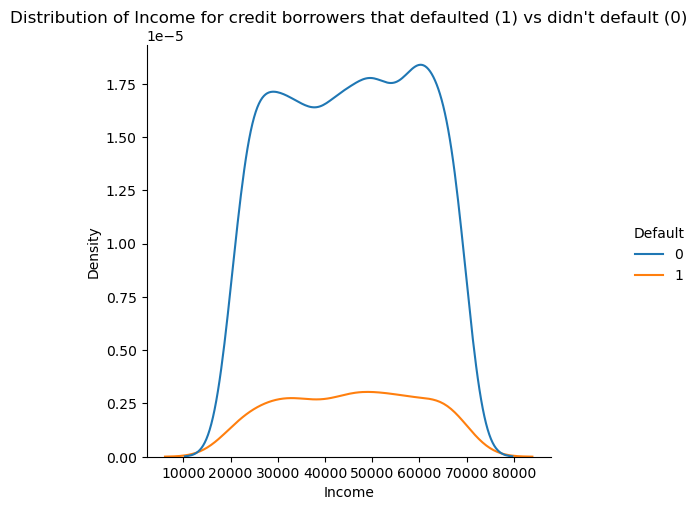

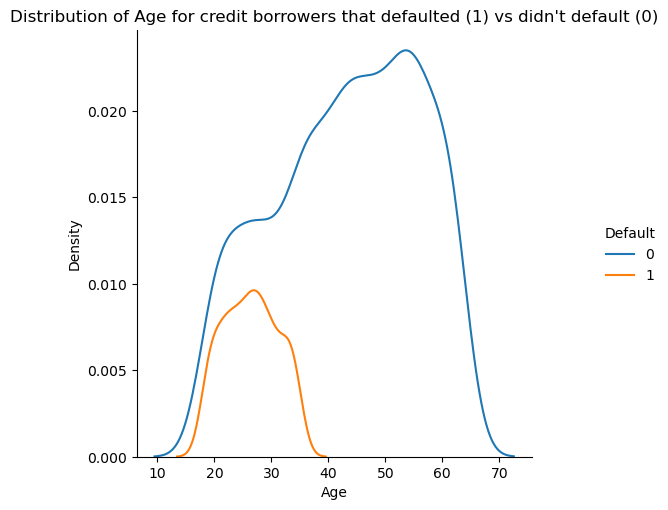

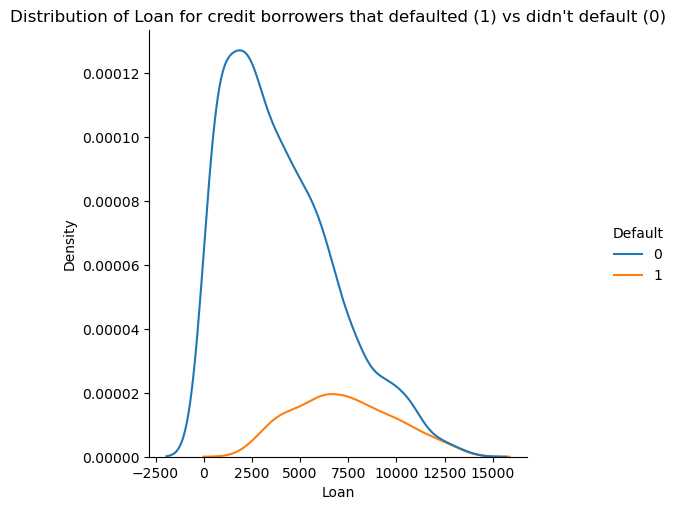

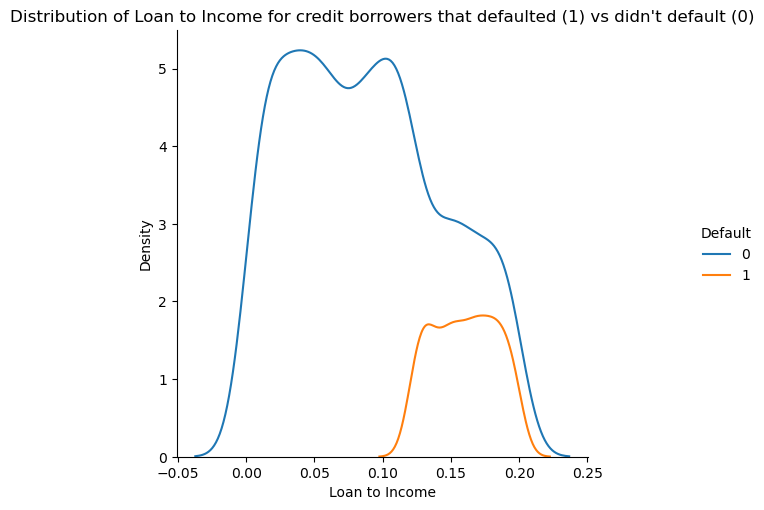

In [110]:
# visual comparison of feature distributions for default vs no default
for feature in features:
    sns.displot(data = df, x=feature, hue='Default', kind='kde')
    plt.title(f"Distribution of {feature} for credit borrowers that defaulted (1) vs didn't default (0)")
    plt.show()

In [111]:
# extract data as numpy arrays
X = df[features].values
y = df['Default'].values

X.shape, y.shape

((2000, 4), (2000,))

In [112]:
# fix y values to be in [-1, 1] since that's how the model is set up
y[y == 0] = -1

In [113]:
# split into train and test data
X_train, y_train, X_test, y_test = split_dataset(X, y, test_size=0.2, shuffle=True)

assert X_train.shape[0] + X_test.shape[0] == X.shape[0]
assert y_train.shape[0] + y_test.shape[0] == y.shape[0]

In [114]:
# min-max scale training data
X_train_min = X_train.min(axis=0)
X_train_max = X_train.max(axis=0)

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)

# scale test data based on max/min from training data to avoid data leakage
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

In [115]:
# initialize model
model = SupportVectorMachine(task='classification')

# fit to training data
model.fit(X_train, y_train)

# accuracy on test set
print(f'Test accuracy: {model.accuracy(X_test, y_test)}')

Test accuracy: 0.9475


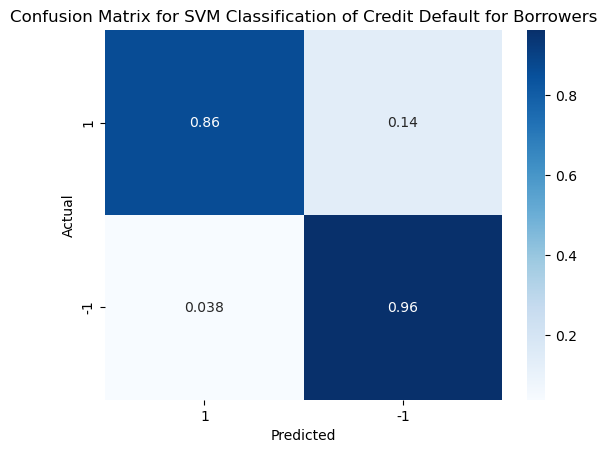

In [116]:
# construct confusion matrix
y_out = model(X_test)

positive_mask = y_out == 1
negative_mask = y_out == -1

true_positive_count = np.sum(y_out[positive_mask] == y_test[positive_mask])
false_positive_count = np.sum(y_out[positive_mask] != y_test[positive_mask])

true_negative_count = np.sum(y_out[negative_mask] == y_test[negative_mask])
false_negative_count = np.sum(y_out[negative_mask] != y_test[negative_mask])

assert true_positive_count + false_positive_count + true_negative_count + false_negative_count == X_test.shape[0]

confusion_matrix = np.array([[true_positive_count, false_negative_count], [false_positive_count, true_negative_count]]).astype(np.float64)

# row-wise normalization
confusion_matrix[0] = confusion_matrix[0] / confusion_matrix[0].sum()
confusion_matrix[1] = confusion_matrix[1] / confusion_matrix[1].sum()

sns.heatmap(confusion_matrix, annot=True, xticklabels=[1, -1], yticklabels=[1, -1], cmap='Blues')

plt.title('Confusion Matrix for SVM Classification of Credit Default for Borrowers')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

The test accuracy of 94.75 % along with the type I and type II error rates of 0.038 and 0.14 respectively indicate strong predictive power.

# Variable Selection

I'll attempt to construct a model without Loan and Income as features and see how it performs.

My reasoning for removing Loan to Income is that it is highly correlated with Loan (r^2 = 0.85)

It's worth mentioning that ideally I'd be a little more scientific about this - perhaps use ANOVA or implement stepwise selection, but I haven't built those tools yet so for now I'll simply eyeball this. However, in a real-world setting, I would of course use scikit-learn's implementations.

In [117]:
X_reduced = df[['Loan', 'Age', 'Income']].values

X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced = split_dataset(X_reduced, y, test_size=0.2, shuffle=True)

# min-max scale training data
X_train_min_reduced = X_train_reduced.min(axis=0)
X_train_max_reduced = X_train_reduced.max(axis=0)

X_train_reduced = (X_train_reduced - X_train_min_reduced) / (X_train_max_reduced - X_train_min_reduced)

# scale test data based on max/min from training data to avoid data leakage
X_test_reduced = (X_test_reduced - X_train_min_reduced) / (X_train_max_reduced - X_train_min_reduced)

In [118]:
# initialize model
model_reduced = SupportVectorMachine(task='classification')

# fit to training data
model_reduced.fit(X_train_reduced, y_train_reduced)

# accuracy on test set
print(f'Test accuracy: {model_reduced.accuracy(X_test_reduced, y_test_reduced)}')

Test accuracy: 0.955


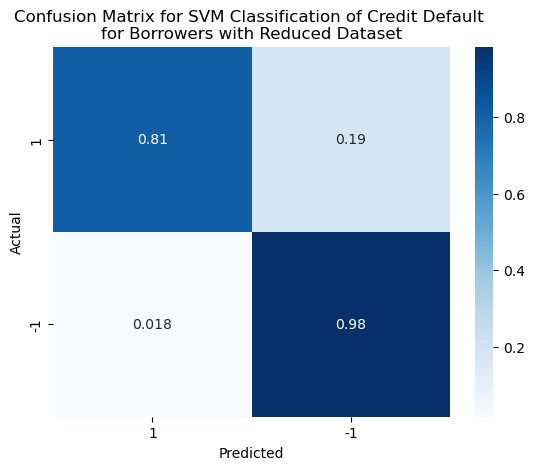

In [119]:
# construct confusion matrix
y_out = model_reduced(X_test_reduced)

positive_mask = y_out == 1
negative_mask = y_out == -1

true_positive_count = np.sum(y_out[positive_mask] == y_test_reduced[positive_mask])
false_positive_count = np.sum(y_out[positive_mask] != y_test_reduced[positive_mask])

true_negative_count = np.sum(y_out[negative_mask] == y_test_reduced[negative_mask])
false_negative_count = np.sum(y_out[negative_mask] != y_test_reduced[negative_mask])

assert true_positive_count + false_positive_count + true_negative_count + false_negative_count == X_test_reduced.shape[0]

confusion_matrix = np.array([[true_positive_count, false_negative_count], [false_positive_count, true_negative_count]]).astype(np.float64)

# row-wise normalization
confusion_matrix[0] = confusion_matrix[0] / confusion_matrix[0].sum()
confusion_matrix[1] = confusion_matrix[1] / confusion_matrix[1].sum()

sns.heatmap(confusion_matrix, annot=True, xticklabels=[1, -1], yticklabels=[1, -1], cmap='Blues')

plt.title('Confusion Matrix for SVM Classification of Credit Default \nfor Borrowers with Reduced Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

As suspected, the reduced model achieves similar performance to the full model, indicating the Loan to Income feature may not be necessary. 